In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 3501, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 3501 (delta 295), reused 290 (delta 189), pack-reused 3054
Receiving objects: 100% (3501/3501), 1.05 GiB | 36.01 MiB/s, done.
Resolving deltas: 100% (2777/2777), done.
Updating files: 100% (312/312), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 23.2 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.9 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv


# Configurations

In [6]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [7]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [8]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2157


In [9]:
config = {
    'tune_parameters': True,
    'database_path': '/kaggle/working/tuning_als_implicit.db',
    'train_best_model': False,
    'copy_prev_best_params': True,
    'save_github': True
}

In [10]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_als_implicit.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [13]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


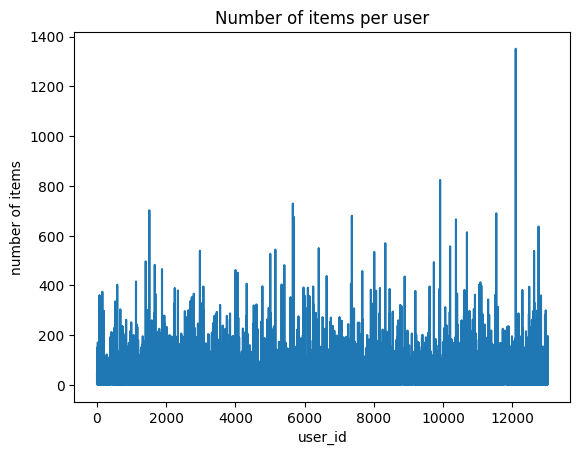

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

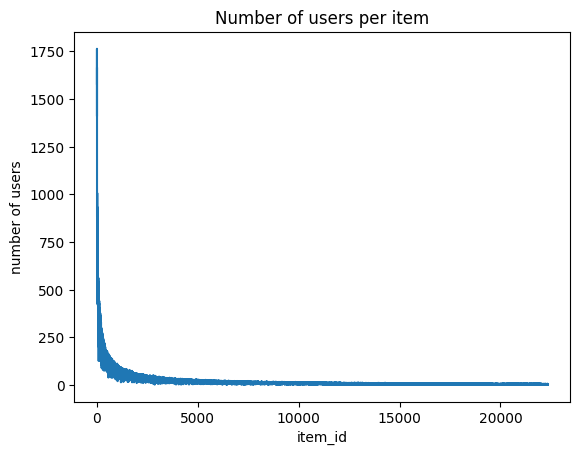

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


# Experiments

In [21]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.BaseRecommender import BaseRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [22]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [23]:
import implicit


class ALSImplicitRecommender(BaseRecommender):
    def __init__(self, URM_train):
        super(ALSImplicitRecommender, self).__init__(URM_train)
        
    def fit(self, factors=50, iterations=10, regularization=1e-2, alpha=1, random_state=None):
        self.model = implicit.als.AlternatingLeastSquares(
            factors=factors,
            iterations=iterations,
            regularization=regularization,
            alpha=alpha,
            dtype=np.float32,
            random_state=random_state
        )
        self.model.fit(self.URM_train)
        
    def recommend(self, user_id_array, cutoff=10, remove_seen_flag=True, items_to_compute=None,
                  remove_top_pop_flag=False, remove_custom_items_flag=False, return_scores=False):
        
        ids, scores = self.model.recommend(user_id_array, self.URM_train[user_id_array], N=cutoff, 
                                           items=items_to_compute, filter_already_liked_items=remove_seen_flag)
        ids = np.array(ids)
        scores = np.array(scores)
        if return_scores:
            total_scores = np.ones((len(user_id_array), self.n_items)) * (-np.inf)
            for i in range(len(user_id_array)):
                total_scores[i, ids[i, :]] = scores[i, :]
            return ids, total_scores
        return ids
    
    def save_model(self, folder_path, file_name=None):
        if file_name is None:
            file_name = 'als'
        self.model.save(os.path.join(folder_path, file_name))
        
    def load_model(self, folder_path, file_name=None):
        if file_name is None:
            file_name = 'als.npz'
        self.model = implicit.recommender_base.RecommenderBase.load(os.path.join(folder_path, file_name))

In [24]:
recommender = ALSImplicitRecommender(URM_train)
recommender.fit(factors=50, random_state=42)

evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 10.99 sec. Users per second: 952


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.060597,0.105652,0.089129,0.030898,0.05329,0.200811,0.099734,0.072144,0.388581,0.247717,...,0.802826,0.311963,0.802826,0.007944,7.897732,0.994748,0.022921,0.608411,2.403395,0.263876


# Hyperparameters tuning

In [25]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

Error reading data from table 'studies': no such table: studies


# Alternating Least Squares

In [26]:
def objective_als(trial):
    params = {
        'regularization': trial.suggest_float('regularization', 1e-7, 1000, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 100, log=True),
        'factors': trial.suggest_int('factors', 5, 1000, log=True),
        'iterations': trial.suggest_int('iterations', 2, 300, log=True),
        'random_state': 42
    }

    recommender = ALSImplicitRecommender(URM_train)
    recommender.fit(**params)

    result_df, _ = evaluator.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

In [27]:
%%time

if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_als_no_cv',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    
    study.optimize(objective_als, n_trials=20)

[I 2023-12-11 06:33:13,984] A new study created in RDB with name: hyperparameters_tuning_als_no_cv


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/7 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.46 sec. Users per second: 1000


[I 2023-12-11 06:33:28,954] Trial 0 finished with value: 0.014006095839253758 and parameters: {'regularization': 0.03733007141504545, 'alpha': 0.26862305914872825, 'factors': 5, 'iterations': 7}. Best is trial 0 with value: 0.014006095839253758.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/21 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 11.91 sec. Users per second: 878


[I 2023-12-11 06:35:07,197] Trial 1 finished with value: 0.03436175098067828 and parameters: {'regularization': 0.003428911740292236, 'alpha': 17.973484302632848, 'factors': 451, 'iterations': 21}. Best is trial 1 with value: 0.03436175098067828.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/13 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 11.82 sec. Users per second: 884


[I 2023-12-11 06:36:09,201] Trial 2 finished with value: 0.03766672283552591 and parameters: {'regularization': 96.36477145437821, 'alpha': 53.12399910694412, 'factors': 419, 'iterations': 13}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/62 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.59 sec. Users per second: 987


[I 2023-12-11 06:37:20,081] Trial 3 finished with value: 0.02398567010966599 and parameters: {'regularization': 6.213986508296157e-06, 'alpha': 20.793664348823643, 'factors': 15, 'iterations': 62}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/9 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 14.62 sec. Users per second: 715


[I 2023-12-11 06:39:27,508] Trial 4 finished with value: 0.020985452265578464 and parameters: {'regularization': 0.010935273156659394, 'alpha': 0.02708035396772759, 'factors': 977, 'iterations': 9}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/2 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 12.51 sec. Users per second: 835


[I 2023-12-11 06:39:46,924] Trial 5 finished with value: 0.02132548259676225 and parameters: {'regularization': 8.233079182907467, 'alpha': 31.799741758461533, 'factors': 396, 'iterations': 2}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/25 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 14.30 sec. Users per second: 731


[I 2023-12-11 06:43:33,944] Trial 6 finished with value: 0.018821197823684417 and parameters: {'regularization': 0.0012885869056284375, 'alpha': 0.017358118413250335, 'factors': 788, 'iterations': 25}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/3 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.42 sec. Users per second: 1004


[I 2023-12-11 06:43:46,444] Trial 7 finished with value: 0.01167897447808501 and parameters: {'regularization': 740.6000004549602, 'alpha': 0.8073884289304825, 'factors': 13, 'iterations': 3}. Best is trial 2 with value: 0.03766672283552591.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/148 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 14.40 sec. Users per second: 726


[I 2023-12-11 07:07:46,496] Trial 8 finished with value: 0.038910669502435345 and parameters: {'regularization': 5.230340393272498, 'alpha': 0.44112377088094995, 'factors': 827, 'iterations': 148}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/5 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 12.19 sec. Users per second: 858


[I 2023-12-11 07:08:12,173] Trial 9 finished with value: 0.02152780434412989 and parameters: {'regularization': 0.0026292116284915372, 'alpha': 0.001530006403939191, 'factors': 267, 'iterations': 5}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/240 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.78 sec. Users per second: 970


[I 2023-12-11 07:15:59,981] Trial 10 finished with value: 0.03421565501997834 and parameters: {'regularization': 2.365678406156541, 'alpha': 1.9574960273979538, 'factors': 95, 'iterations': 240}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/254 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.67 sec. Users per second: 980


[I 2023-12-11 07:24:44,659] Trial 11 finished with value: 0.03192248925201323 and parameters: {'regularization': 251.70614446580657, 'alpha': 78.73333682823976, 'factors': 176, 'iterations': 254}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/74 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.95 sec. Users per second: 955


[I 2023-12-11 07:27:15,607] Trial 12 finished with value: 0.03597237023475583 and parameters: {'regularization': 10.46812817563223, 'alpha': 4.465141472014696, 'factors': 148, 'iterations': 74}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/14 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 12.39 sec. Users per second: 844


[I 2023-12-11 07:28:35,396] Trial 13 finished with value: 0.034310151534472894 and parameters: {'regularization': 0.4905777500244301, 'alpha': 4.5111642583214895, 'factors': 533, 'iterations': 14}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/44 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 13.73 sec. Users per second: 762


[I 2023-12-11 07:39:01,443] Trial 14 finished with value: 0.0004955042141824847 and parameters: {'regularization': 102.88714625528684, 'alpha': 0.14999945796417097, 'factors': 892, 'iterations': 44}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/109 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 11.84 sec. Users per second: 883


[I 2023-12-11 07:44:05,965] Trial 15 finished with value: 0.037621863652372856 and parameters: {'regularization': 27.82381678100813, 'alpha': 7.999001457621625, 'factors': 280, 'iterations': 109}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/29 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.85 sec. Users per second: 964


[I 2023-12-11 07:45:02,995] Trial 16 finished with value: 0.018389851349874347 and parameters: {'regularization': 0.5641030479299155, 'alpha': 79.9421086362084, 'factors': 47, 'iterations': 29}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/13 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 12.67 sec. Users per second: 825


[I 2023-12-11 07:50:00,959] Trial 17 finished with value: 0.0021090116102549226 and parameters: {'regularization': 772.5389248982416, 'alpha': 1.0397445066474844, 'factors': 515, 'iterations': 13}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/142 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 11.00 sec. Users per second: 951


[I 2023-12-11 07:56:17,750] Trial 18 finished with value: 0.038840788610777596 and parameters: {'regularization': 31.51907913706554, 'alpha': 2.252480101728631, 'factors': 268, 'iterations': 142}. Best is trial 8 with value: 0.038910669502435345.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.


  0%|          | 0/158 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10456 (100.0%) in 10.74 sec. Users per second: 974


[I 2023-12-11 08:02:11,489] Trial 19 finished with value: 0.024406371066661818 and parameters: {'regularization': 0.18115279080643418, 'alpha': 0.5209682945590277, 'factors': 199, 'iterations': 158}. Best is trial 8 with value: 0.038910669502435345.


CPU times: user 4h 4min 18s, sys: 1h 33min 53s, total: 5h 38min 12s
Wall time: 1h 28min 58s


In [28]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [29]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [30]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [31]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_als.json', 'w') as params_file:
        params = study.best_params
        json.dump(params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_als.json', 
            'tuning_results/best_params_als.json', 
            'ALS with implicit tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_als.json', 
        '/kaggle/working/best_params_als.json'
    )

In [32]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        'tuning_results/tuning_als_implicit.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [33]:
if config['train_best_model']:
    with open('/kaggle/working/best_params_als.json', 'r') as params_file:
        params = json.load(params_file)
    
    recommender = ALSImplicitRecommender(URM_all)
    recommender.fit(**params)
    
    recommender.save_model(folder_path='/kaggle/working/', file_name='als_all')
    
    if config['save_github']: 
        upload_file(
            '/kaggle/working/als_all.zip', 
            'models/als_all.zip', 
            'ALS best model'
        )